In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
pd.set_option('max_rows', 5)
pd.set_option('max_columns', 9)
%matplotlib inline

# 決定木 (decision tree)
---
IF文の連続で結果を予測するモデル。精度は低いが、結果に対する説明力 (理由の理解しやすさ) が高い。  
元のデータを根 (root) ・分類の最終点を葉 (leaf) ・根から葉に至る途中を枝 (branch) と呼ぶ。

In [2]:
from my_functions.decision_tree import algorithm
algorithm.show()

Play(value=1, interval=1000, max=5, min=1)

Output()

## 分割指標
---
決定木は、情報の不純度 (Impurity) が最も下がる条件で枝を分岐していく。分類の場合、1つのクラスだけで葉が構築されていれば不純度は低く、様々なクラスが混じっていると不純度は高くなる。

不純度の指標には以下のような種類がある。

### ジニ不純度
---
サンプルに含まれるクラスの数を $c$、枝候補中でクラス $i$ に属するサンプルの割合を $p_{i}$ とすると、  
ジニ不純度 ${\displaystyle I=1-\sum ^{c}_{i=1} p^{2}_{i}}$

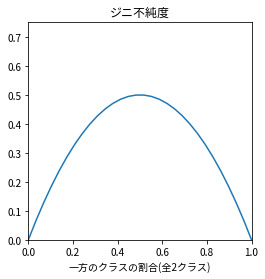

In [3]:
from my_functions.decision_tree import criteria
criteria.show('gini')

練習問題

---
`leaf`データセットのジニ不純度を算出する。

In [4]:
np.random.seed(1234)
leaf = pd.Series(pd.Categorical(
    np.random.choice(('A', 'B', 'C'), size=10, p=(0.2, 0.3, 0.5))),
                 name='leaf')
print('leaf')
display(leaf)

leaf


0    A
1    C
    ..
8    C
9    C
Name: leaf, Length: 10, dtype: category
Categories (3, object): [A, B, C]

解答例

---

In [5]:
p = leaf.groupby(leaf).count() / leaf.count()
1 - np.sum(p**2)

0.54

---

### エントロピー
---
サンプルに含まれるクラスの数を $c$、枝候補中でクラス $i$ に属するサンプルの割合を $p_{i}$ とすると、  
エントロピー ${\displaystyle I=-\sum ^{c}_{i=1} p_{i} \cdot log( p_{i})}$

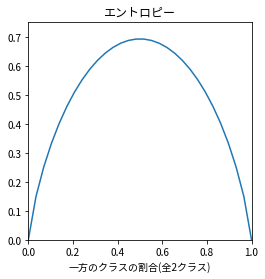

In [6]:
from my_functions.decision_tree import criteria
criteria.show('entropy')

対数の底は何でもよいが、クラス数 $c$ にするとエントロピーの最大値が 1 となる。

練習問題

---
`leaf`データセットのエントロピーを算出する。

解答例

---

In [7]:
p = leaf.groupby(leaf).count() / leaf.count()
-np.sum(p * np.log(p))

0.8979457248567797

---

### $\chi ^{2}$ (カイ二乗) 統計量
---
説明変数 $x$ ・目的変数 $y$ のクロス集計表におけるセル $\left( x_{i},y_{j}\right)$ の観測度数を $o_{ij}$ ・期待度数 $e_{ij}$ とすると  
カイ二乗統計量 $\displaystyle \chi ^{2} =\sum ^{k}_{i=1}\sum ^{c}_{j=1}\frac{( o_{ij} -e_{ij})^{2}}{e_{ij}}$

[$\chi ^{2}$ (カイ二乗) 検定](crosstab_test.ipynb#%E3%82%AB%E3%82%A4%E4%BA%8C%E4%B9%97%E6%A4%9C%E5%AE%9A)を参照。

## 分割アルゴリズム

### CART
---
2 分岐のみで構築するアルゴリズム。  
親ノードを $p$ ・子ノード (枝) 候補を $c$ とすると、親ノードの不純度から子ノードの不純度の加重平均を引いた情報利得 (Information Gain) $\displaystyle G=I( p) -\sum ^{2}_{i=1}\frac{N_{c_{i}}}{N_{p}} I( c_{i})$ が最大になる (分割後の不純度が最小になる) 値で分割する。 (回帰木の場合は不純度にノード内分散を用いる)  
本来の CART アルゴリズムは分割指標 $I$ にジニ不純度を使用しているが、エントロピーなどを使ってもよい。 (エントロピーを使った場合はC4.5・C5.0アルゴリズムを 2 分岐に制限したものに近い)

<table class="text-center">
    <tr>
        <th>分岐</th>
        <td>二分木のみ</td>
    </tr>
    <tr>
        <th>分割指標</th>
        <td>ジニ不純度 (エントロピーなども使用可)</td>
    </tr>
    <tr>
        <th>目的変数</th>
        <td>質的変数 (分類) ・量的変数 (回帰)</td>
    </tr>
    <tr>
        <th>説明変数</th>
        <td>質的変数 (ダミー変数化する) ・量的変数</td>
    </tr>
</table>

scikit-learn は CART アルゴリズムで実装されている。

練習問題

---
`iris`データセットをジニ不純度を基準に`petal_width`が1.75以上かどうかで分けたときの情報利得を算出する。

In [8]:
iris = sns.load_dataset('iris')
print('iris')
display(iris)

iris


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
...,...,...,...,...,...
148,6.2,3.4,5.4,2.3,virginica
149,5.9,3.0,5.1,1.8,virginica


解答例

---

In [9]:
def gini(x):
    return 1 - np.sum((x.groupby(x).count() / x.count())**2)


division = 1.75
parent = iris['species']
left = iris.query('petal_width >= @division')['species']
right = iris.query('petal_width < @division')['species']
gain = gini(parent) - sum(
    [c.size / parent.size * gini(c) for c in (left, right)])
print(f'Information Gain : {gain:.3f}')

Information Gain : 0.276


---

### C4.5・C5.0
---
多分岐も構築できるアルゴリズム。  
CART アルゴリズムと同じく、情報利得 (Information Gain) $\displaystyle G=I( p) -\sum ^{2}_{i=1}\frac{N_{c_{i}}}{N_{p}} I( c_{i})$ が最大になる値で分割するが、不純度にエントロピーを使用する。

<table class="text-center">
    <tr>
        <th>分岐</th>
        <td>多分岐可能</td>
    </tr>
    <tr>
        <th>分割指標</th>
        <td>エントロピー</td>
    </tr>
    <tr>
        <th>目的変数</th>
        <td>質的変数 (分類)</td>
    </tr>
    <tr>
        <th>説明変数</th>
        <td>質的変数・量的変数</td>
    </tr>
</table>

練習問題

---
`iris`データセットをエントロピーを基準に`petal_width`が1.75以上かどうかで分けたときの情報獲得量を算出する。

解答例

---

In [10]:
def entropy(x):
    p = x.groupby(x).count() / x.count()
    return -np.sum(p * np.log(p))


division = 1.75
parent = iris['species']
left = iris.query('petal_width >= @division')['species']
right = iris.query('petal_width < @division')['species']
gain = entropy(parent) - sum(
    [c.size / parent.size * entropy(c) for c in (left, right)])
print(f'Information Gain : {gain:.3f}')

Information Gain : 0.475


---

### CHAID
---
多分岐も構築できるアルゴリズム。  
$\chi ^{2}$ 統計量の $p$ 値が最も低くなる値で分割する。 (ただし、$p$ 値が有意水準を上回っている場合はそれ以上の分岐を止める)

<table class="text-center">
    <tr>
        <th>分岐</th>
        <td>多分岐可能</td>
    </tr>
    <tr>
        <th>分割指標</th>
        <td>$\chi ^{2}$ 統計量 ($p$ 値)</td>
    </tr>
    <tr>
        <th>目的変数</th>
        <td>質的変数 (分類)</td>
    </tr>
    <tr>
        <th>説明変数</th>
        <td>質的変数・量的変数 (内部的に離散化して質的変数として扱う)</td>
    </tr>
</table>

## Pythonでの決定木の実行方法
---
`sklearn.tree.DecisionTreeClassifier`を使用する。

In [11]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort='deprecated', ccp_alpha=0.0)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choos

In [12]:
model = DecisionTreeClassifier()
model.fit(iris.iloc[:, :-1], iris.iloc[:, -1])

DecisionTreeClassifier()

構築された木の可視化には`sklearn.tree.export.plot_tree`を使用する。

In [13]:
help(plot_tree)

Help on function plot_tree in module sklearn.tree._export:

plot_tree(decision_tree, *, max_depth=None, feature_names=None, class_names=None, label='all', filled=False, impurity=True, node_ids=False, proportion=False, rotate='deprecated', rounded=False, precision=3, ax=None, fontsize=None)
    Plot a decision tree.
    
    The sample counts that are shown are weighted with any sample_weights that
    might be present.
    
    The visualization is fit automatically to the size of the axis.
    Use the ``figsize`` or ``dpi`` arguments of ``plt.figure``  to control
    the size of the rendering.
    
    Read more in the :ref:`User Guide <tree>`.
    
    .. versionadded:: 0.21
    
    Parameters
    ----------
    decision_tree : decision tree regressor or classifier
        The decision tree to be plotted.
    
    max_depth : int, optional (default=None)
        The maximum depth of the representation. If None, the tree is fully
        generated.
    
    feature_names : list of st

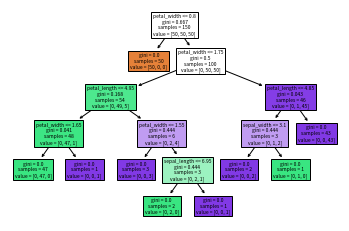

In [14]:
plot_tree(model, feature_names=iris.columns[:-1], filled=True)
plt.show()

Python 3.6 以上なら[dtreeviz](https://github.com/parrt/dtreeviz)を使ってみてもいい。

練習問題

---
`wine`データセットから深さ 3 の決定木 (分類木) を構築し、可視化する。

In [15]:
loader = load_wine()
wine = pd.DataFrame(np.column_stack([loader.data, loader.target]),
                    columns=loader.feature_names + ['target'])
print('wine')
display(wine)

wine


,alcohol,malic_acid,ash,alcalinity_of_ash,...,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,...,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,...,1.05,3.40,1050.0,0.0
...,...,...,...,...,...,...,...,...,...
176,13.17,2.59,2.37,20.0,...,0.60,1.62,840.0,2.0
177,14.13,4.10,2.74,24.5,...,0.61,1.60,560.0,2.0


解答例

---

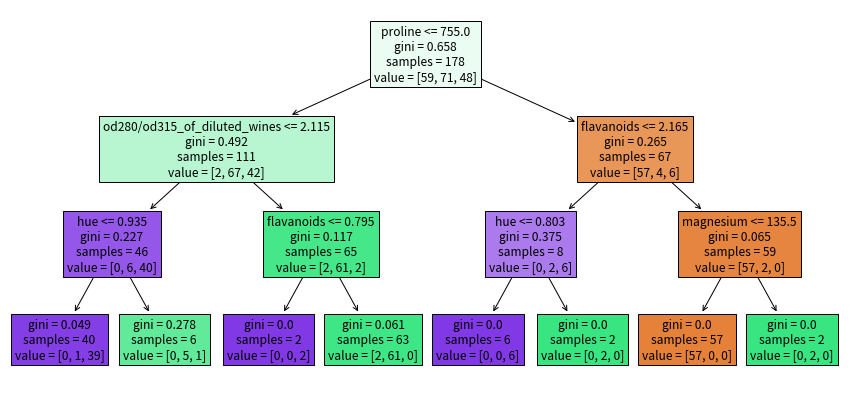

In [16]:
model = DecisionTreeClassifier(max_depth=3).fit(wine.iloc[:, :-1],
                                                wine['target'])
plt.figure(figsize=(15, 7))
plot_tree(model, feature_names=wine.columns[:-1], filled=True, fontsize='large')
plt.show()

---

## 推薦図書
---
- [Python 機械学習プログラミング 達人データサイエンティストによる理論と実践](https://www.amazon.co.jp/Python-%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0-%E9%81%94%E4%BA%BA%E3%83%87%E3%83%BC%E3%82%BF%E3%82%B5%E3%82%A4%E3%82%A8%E3%83%B3%E3%83%86%E3%82%A3%E3%82%B9%E3%83%88%E3%81%AB%E3%82%88%E3%82%8B%E7%90%86%E8%AB%96%E3%81%A8%E5%AE%9F%E8%B7%B5-impress-gear/dp/4295003379/)